In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
from tqdm import tqdm

In [2]:
RANDOM_SEED = 69
random.seed(RANDOM_SEED)

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [4]:
print(f'Entrenamiento: {df_train.id_code.count()}, Prueba: {df_test.id_code.count()}')

Entrenamiento: 3662, Prueba: 1928


In [5]:
TRAIN_SIZE = 0.85
split_index = round(df_train.id_code.count() * TRAIN_SIZE)
train_images = df_train.loc[0:split_index-1]['id_code']
train_labels = df_train.loc[0:split_index-1]['diagnosis']
test_images = df_train.loc[split_index:]['id_code']
test_labels = df_train.loc[split_index:]['diagnosis']

In [6]:
print(f'Entrenamiento: {len(train_images)}, Validación: {len(test_images)}')

Entrenamiento: 3113, Validación: 549


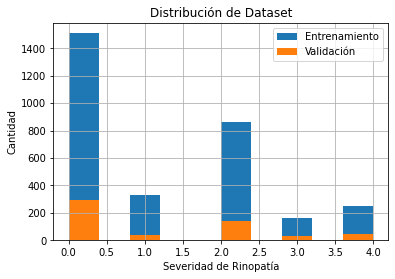

In [7]:
labels = ['0', '1', '2', '3', '4']
fig, ax = plt.subplots()
plt.subplot(train_labels.hist(label='Entrenamiento'))
plt.subplot(test_labels.hist(label='Validación'))
ax.set_title('Distribución de Dataset')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Severidad de Rinopatía')
ax.legend()
plt.show()

# Blurring

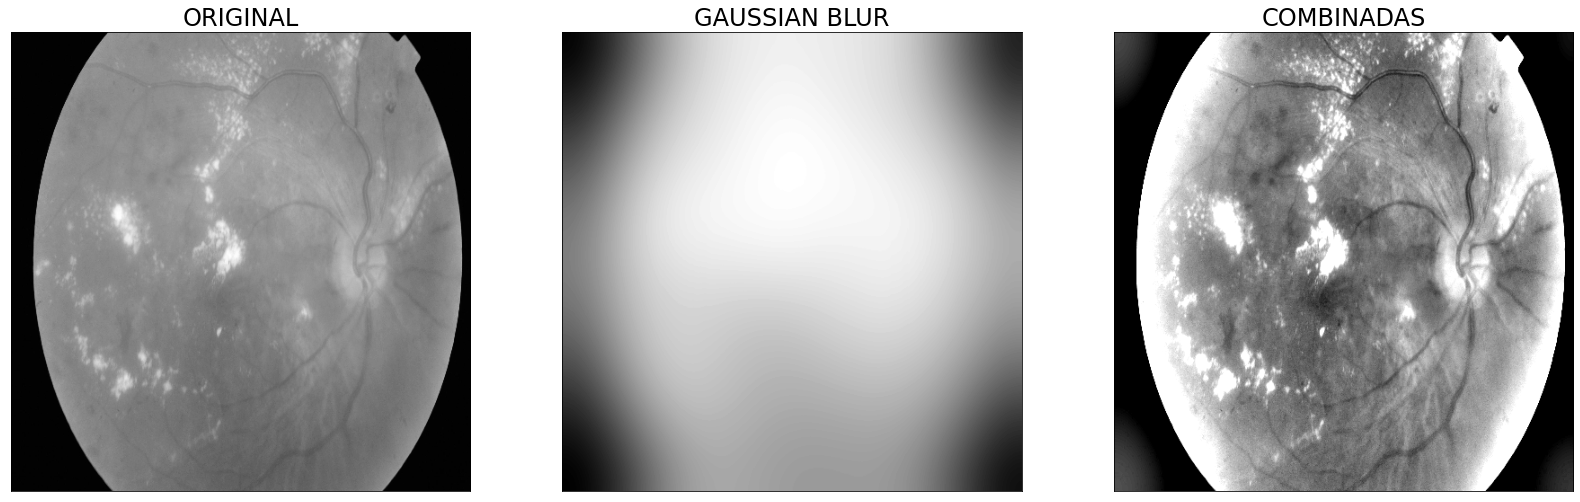

In [8]:
IMG_SIZE = 512
path = './data_img/train_images/0c917c372572.png'

GAUSS_KERNEL_SIZE = (0, 0)
GAUSS_SIGMA_X = 50
WEIGHT = 4

original_img = cv2.imread(path)
original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

def apply_gauss_blur(img, ksize=(0,0), sigma_x=50, gamma=128):
    """
    Aplicar Gaussian Blur a img.
    """
    gauss = cv2.GaussianBlur(img, ksize, sigma_x)
    img = cv2.addWeighted(img, WEIGHT, gauss, -WEIGHT, gamma)
    
    return img

filtered_img = apply_gauss_blur(original_img)
blurred_img = cv2.GaussianBlur(original_img, GAUSS_KERNEL_SIZE, GAUSS_SIGMA_X)

fontdict = {'fontsize':24}
fig = plt.figure(figsize=(28, 28))
ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.set_title('ORIGINAL', fontdict)
plt.imshow(original_img, cmap='gray')
ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.set_title('GAUSSIAN BLUR', fontdict)
plt.imshow(blurred_img, cmap='gray')
ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.set_title('COMBINADAS', fontdict)
plt.imshow(filtered_img, cmap='gray')

### Detección de Orillas - Laplacian y Sobel
- Se comparan los resultados obtenidos con los distintos métodos.
- El método de Sobel con diferenciación sobre el eje y parece ser interesante.

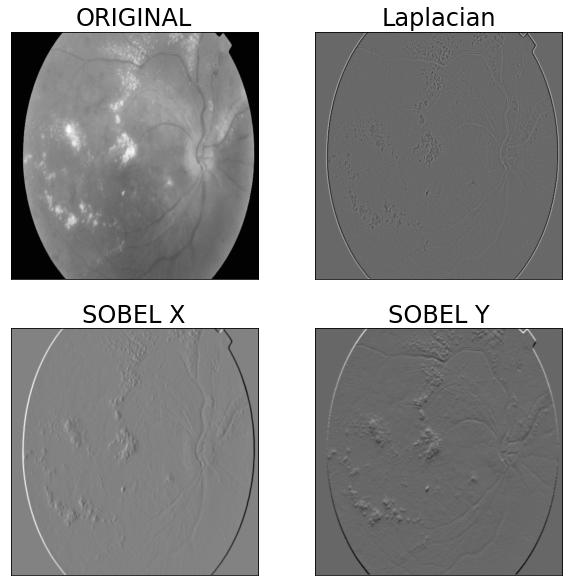

In [11]:
IMG_SIZE = 512
path = './data_img/train_images/0c917c372572.png'

original_img = cv2.imread(path)
original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(gray,(3,3),0)
laplacian = cv2.Laplacian(img, cv2.CV_64F)
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=-1)
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=-1)

fontdict = {'fontsize':24}
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 2, 1, xticks=[], yticks=[])
ax.set_title('ORIGINAL', fontdict)
plt.imshow(gray, cmap='gray')
ax = fig.add_subplot(2, 2, 2, xticks=[], yticks=[])
ax.set_title('Laplacian', fontdict)
plt.imshow(laplacian, cmap='gray')
ax = fig.add_subplot(2, 2, 3, xticks=[], yticks=[])
ax.set_title('SOBEL X', fontdict)
plt.imshow(sobel_x, cmap='gray')
ax = fig.add_subplot(2, 2, 4, xticks=[], yticks=[])
ax.set_title('SOBEL Y', fontdict)
plt.imshow(sobel_y, cmap='gray')

### Orillas
Fuente: https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv
- Se realiza un recorte rectangular para reducir la cantidad de información inutil en las imágenes.

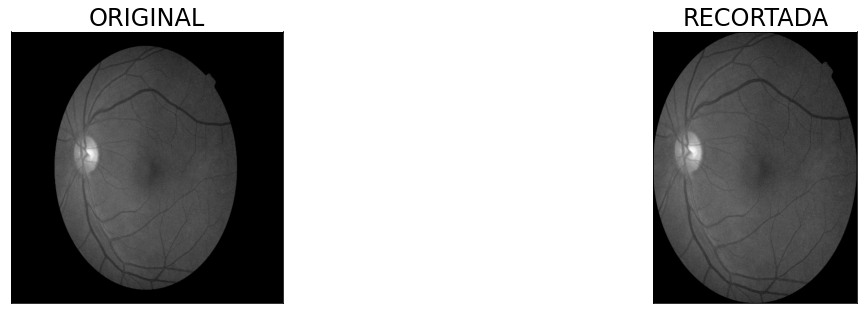

In [12]:
IMG_SIZE = 512
path = './data_img/train_images/0a74c92e287c.png'
original_img = cv2.imread(path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))

def crop_image(img, tolerance=7):
    if img.ndim == 2:
        mask = img > tolerance
        return img[np.ix_(mask.any(1), mask.any(0))]
    else:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tolerance
        
        check = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check == 0:
            return img
        img = np.stack([
            img[:,:,0][np.ix_(mask.any(1), mask.any(0))],
            img[:,:,1][np.ix_(mask.any(1), mask.any(0))],
            img[:,:,2][np.ix_(mask.any(1), mask.any(0))],
        ], axis=-1)
        
        return img

cropped_img = crop_image(original_img)

# mostrar antes y despues
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax.set_title('ORIGINAL', fontdict)
ax
plt.imshow(original_img, cmap='gray')
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.set_title('RECORTADA', fontdict)
plt.imshow(cropped_img, cmap='gray')